In [21]:

import torch
import torchvision
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:


training_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.ToTensor()),
                     batch_size=64, shuffle=True)
validation_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=False, download=True, transform=torchvision.transforms.ToTensor()),
                     batch_size=64, shuffle=False)



In [23]:

class MaskedConv2d(torch.nn.Conv2d):
    def __init__(self, mask_type, *arg, **kwargs):
        super().__init__(*arg, **kwargs)
        assert mask_type in ["A", "B"], "Invalid mask type"
        self.mask = torch.ones_like(self.weight.data)
        batch_size, channels, height, width = self.mask.shape
        if mask_type == "A":
            self.mask[:,:,height//2:, width//2:] = 0
            self.mask[:,:,height//2+1:, :] = 0
        elif mask_type == "B":
            self.mask[:,:,height//2:, width//2+1:] = 0
            self.mask[:,:,height//2+1:, :] = 0
        self.mask = self.mask.to(device="cuda")
            
    def forward(self, image):
        self.weight.data = self.weight.data * self.mask
        return super(MaskedConv2d, self).forward(image)





In [24]:

class PixelCNN(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size_A=7, kernel_size_B=5):
        super(PixelCNN, self).__init__()
        self.model = torch.nn.Sequential(
                MaskedConv2d(mask_type='A', in_channels=in_channels,  out_channels=64, kernel_size=kernel_size_A, stride=1, padding=kernel_size_A//2), 
                torch.nn.BatchNorm2d(64), 
                torch.nn.ReLU(True),

                MaskedConv2d(mask_type='B', in_channels=64,  out_channels=64, kernel_size=kernel_size_B, stride=1, padding=kernel_size_B//2), 
                torch.nn.BatchNorm2d(64), 
                torch.nn.ReLU(True),
                MaskedConv2d(mask_type='B', in_channels=64,  out_channels=64, kernel_size=kernel_size_B, stride=1, padding=kernel_size_B//2), 
                torch.nn.BatchNorm2d(64), 
                torch.nn.ReLU(True),
                MaskedConv2d(mask_type='B', in_channels=64,  out_channels=64, kernel_size=kernel_size_B, stride=1, padding=kernel_size_B//2), 
                torch.nn.BatchNorm2d(64), 
                torch.nn.ReLU(True),
                MaskedConv2d(mask_type='B', in_channels=64,  out_channels=64, kernel_size=kernel_size_B, stride=1, padding=kernel_size_B//2), 
                torch.nn.BatchNorm2d(64), 
                torch.nn.ReLU(True),
                MaskedConv2d(mask_type='B', in_channels=64,  out_channels=64, kernel_size=kernel_size_B, stride=1, padding=kernel_size_B//2), 
                torch.nn.BatchNorm2d(64), 
                torch.nn.ReLU(True),
                MaskedConv2d(mask_type='B', in_channels=64,  out_channels=64, kernel_size=kernel_size_B, stride=1, padding=kernel_size_B//2), 
                torch.nn.BatchNorm2d(64), 
                torch.nn.ReLU(True),
                MaskedConv2d(mask_type='B', in_channels=64,  out_channels=64, kernel_size=kernel_size_B, stride=1, padding=kernel_size_B//2), 
                torch.nn.BatchNorm2d(64), 

                torch.nn.ReLU(True),
                torch.nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)
        )
            
    def forward(self, images):
        pred = self.model(images)
        return pred

pixel_cnn = PixelCNN(in_channels=1, out_channels=256)
pixel_cnn.to(device=device)
optim = torch.optim.Adam(params=pixel_cnn.parameters())


In [25]:

def generate_images(nb_images, images_shape, model, device="cpu"):
    generated_images = torch.randn((64, images_shape[2], images_shape[0], images_shape[1]), device=device)
    for i in range(generated_images.shape[2]):
        for j in range(generated_images.shape[3]):
            pred = model(generated_images)
            prob_current_pixel = torch.nn.functional.softmax(pred[:,:,i,j])
            generated_images[:,:,i,j] = torch.multinomial(prob_current_pixel, 1).float() / 255
    generated_images = torchvision.utils.make_grid(generated_images, nrow=int(np.sqrt(nb_images)))
    generated_images = generated_images.permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(7.5,7.5))
    plt.imshow(generated_images)
    plt.title("Generated image")
    plt.show()



In [26]:

def show_learning_curve(train_loss, val_loss):
    plt.figure(figsize=(7.5,7.5))
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend("Training loss", "Validation loss")
    plt.title("Leaning curve")
    plt.show()



Finish epoch 0. Train_loss = 0.6221436013672144, Val_loss = 0.6195729522948052


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


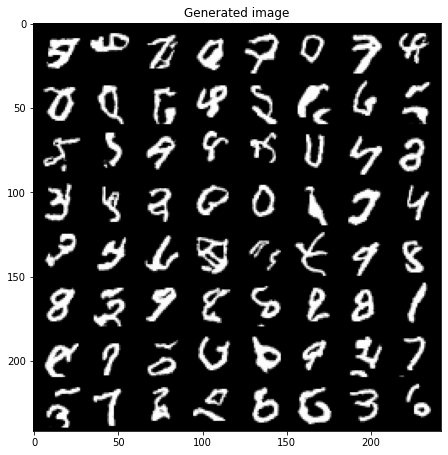

------------------------------------------------------------------------------------






Finish epoch 1. Train_loss = 0.6202771237282865, Val_loss = 0.6154413785144781


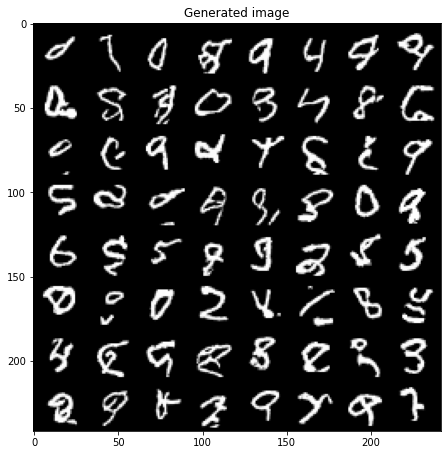

------------------------------------------------------------------------------------






Finish epoch 2. Train_loss = 0.6176963032944116, Val_loss = 0.6162135331494034


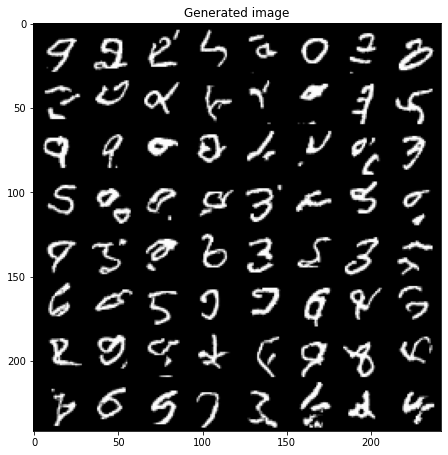

------------------------------------------------------------------------------------






Finish epoch 3. Train_loss = 0.6176599470664189, Val_loss = 0.6163378004815169


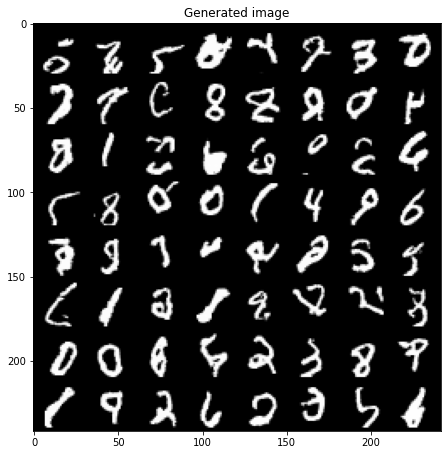

------------------------------------------------------------------------------------






Finish epoch 4. Train_loss = 0.6150533518176089, Val_loss = 0.6928809372482786


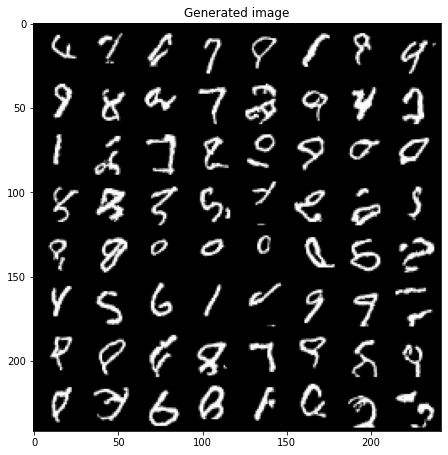

------------------------------------------------------------------------------------





In [30]:

epochs = 25

train_loss = []
validation_loss = []

for epoch in range(epochs):
    # Training 
    epoch_train_loss = []
    pixel_cnn.train()
    for images, labels in tqdm(training_set):
        images = images.to(device=device)
        pred = pixel_cnn(images)
        images = (images[:,0] * 255).long()
        loss = torch.nn.functional.cross_entropy(pred, images)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    # Validation
    epoch_val_loss = []
    pixel_cnn.eval()
    for images, labels in tqdm(validation_set):
        images = images.to(device=device)
        pred = pixel_cnn(images)
        images = (images[:,0] * 255).long()
        loss = torch.nn.functional.cross_entropy(pred, images)
        epoch_val_loss.append(loss.item())

    epoch_train_loss = np.mean(epoch_train_loss)
    epoch_val_loss = np.mean(epoch_val_loss)
    train_loss.append(epoch_train_loss)
    validation_loss.append(validation_loss)
    print(f"Finish epoch {epoch}. Train_loss = {epoch_train_loss}, Val_loss = {epoch_val_loss}")
    
    generate_images(nb_images=64, images_shape=(images.shape[1], images.shape[2], 1), model=pixel_cnn, device=device)

    print("------------------------------------------------------------------------------------")
    print("\n\n")



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


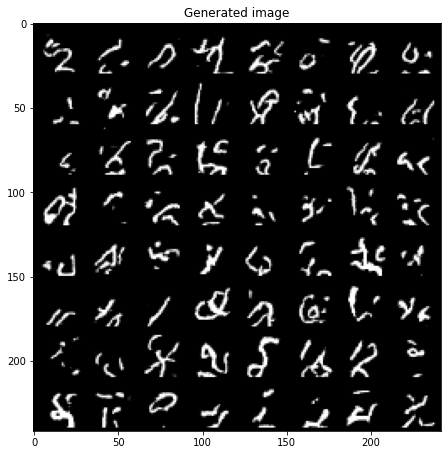

In [17]:
generate_images(nb_images=64, images_shape=(images.shape[1], images.shape[2], 1), model=pixel_cnn, device=device)
